<hr style="height: 4px; color: #839D2D; width: 100%; ">

# <font color='#61210B'>Formation OpenClassRooms   -   Parcours DATA ANALYST</font>

<hr style="height: 2px; color: #839D2D; width: 100%; ">

## <font color='#38610B'>Projet VII - Prédictions de Revenus</font>


#### Mission 4 - ANOVA & Régressions Linéaires

<u>DataFrames pandas utilisés et critères de téléchargement</u> :  

* <font color='#013ADF'>DataFrames <strong>pj7 & wid500</strong></font> : Fichier enrichi, nettoyé avec datas de wid, gini , pop  & gdim et creation de 500 clones.  

 Dataframes issus des l'études précédentes.

  
**<font color='#38610B'>- Date : 5 Aout 2019</font>**  
Auteur : Frédéric Boissy
<hr style="height: 4px; color: #839D2D; width: 100%; ">


#### Initialisation (Libraries - Functions - etc...)

In [1]:
import time   # Librairie temps pour calculs durée par exemple
trt_start_time = time.time()

# -*- coding: utf8 -*-
from init_libraries import *
# /////  Pour executer des requetes SQL de verification sur des DF  /////
from pandasql            import sqldf
execsql = lambda q: sqldf(q, globals())   


# Limiter le nombre de lignes d'affichage des Dataframes
pd.options.display.max_rows=10

#### DEBUGGER python
Ajout de ligne BKP avec commande breakpoint() à l'endroit désiré.  
* Actions autorisées : c/n/s/q
    * c - continue execution
    * n - step to the next line within the same function
    * s - step to the next line in this function or a called function
    * q - quit the debugger/execution


In [2]:
import pdb
# breakpoint()

<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue"> Data "pj7" enrichi de l'etude précédente</font>   
- <b>Données etape2, avec variables gini, income, mais sans classe parents</b>

In [3]:
pj7 = pd.read_csv("OUTFILES/pj7_m3.csv")
pj7.info()
print("Dimension Tableau : ", pj7.shape, "  ///  Nombre de Pays :", pj7.shape[0]/(100), "  ///")
pj7.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11200 entries, 0 to 11199
Data columns (total 6 columns):
country_code    11200 non-null object
c_i_child       11200 non-null int64
pj              11200 non-null float64
income          11200 non-null float64
gini            11200 non-null float64
gdpppp          11200 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 525.1+ KB
Dimension Tableau :  (11200, 6)   ///  Nombre de Pays : 112.0   ///


,country_code,c_i_child,pj,income,gini,gdpppp
0,ALB,1,0.816,728.898,30.300,"7,297.000"
1,ALB,2,0.816,916.662,30.300,"7,297.000"
2,ALB,3,0.816,"1,010.916",30.300,"7,297.000"
3,ALB,4,0.816,"1,086.908",30.300,"7,297.000"
4,ALB,5,0.816,"1,132.700",30.300,"7,297.000"


<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue"> Dataframe "wid500" enrichi de l'etude précédente</font>   
- <b>avec les 500 clones + la variable classe_parent</b>

In [4]:
# wid = pd.read_csv("OUTFILES/wid500.csv")
wid = pd.read_csv("OUTFILES/wid500.zip")
print("Dimension Tableau : ", wid.shape, "  ///  Nombre de Pays :", wid.shape[0]/(100*500), "  ///")
wid.head()

Dimension Tableau :  (5600000, 7)   ///  Nombre de Pays : 112.0   ///


,country_code,c_i_child,pj,income,gini,gdpppp,c_i_parent
0,ALB,1,0.816,728.898,30.300,"7,297.000",1
1,ALB,1,0.816,728.898,30.300,"7,297.000",1
2,ALB,1,0.816,728.898,30.300,"7,297.000",1
3,ALB,1,0.816,728.898,30.300,"7,297.000",1
4,ALB,1,0.816,728.898,30.300,"7,297.000",1


In [5]:
widALB = wid[wid['country_code'] == 'ALB']
req='''
With T1 as (
Select c_i_child, c_i_parent, count(*) as nb
from widALB
group by c_i_child, c_i_parent)
Select sum(nb) from T1
'''
df1 = execsql(req)
df1

,sum(nb)
0,50000


#### A ce stade, et pour éviter toute confusion, je retire la variable  <font color="darkblue" size=4>$C_{(i,child)}$ : </font>
Elle ne nous sera pas utile dans cette partie.

In [6]:
try:
    pj7.drop(columns=['c_i_child'], inplace=True)
    wid.drop(columns=['c_i_child'], inplace=True)
except KeyError:
    print("Suppression deja faite")

<hr style="height: 4px; color: #839D2D; width: 100%; ">

### OBJECTIF  ETUDE

<font color="darkblue" size=3>  
Expliquer le <b>revenu des individus</b> en fonction de plusieurs <b>variables explicatives (facteurs)</b> :    
<i>
* le pays de l'individu
* l'indice de Gini de ce pays
* la classe de revenus des parents, etc.
</font></i>

In [7]:
lib_pays = ["Iceland", "France", "Slovenia", "Argentina", "Honduras", "Indonesia"]
cod_pays = ["ISL", "FRA", "SVN", "ARG", "HND", "IDN"]
col_pays = ["#8000FF", "#0040FF", "#DF7401", "#81DAF5", "green", "red"]

<hr style="height: 3px; color: #839D2D; width: 100%; ">

##  <font color='#61210B'><u>M4 - ANOVA</u></font>

- Le test <b>d'ANOVA</b> (analyse de la variance) ou <b>R² (η²)</b> permet de savoir si une donnée qualitative et une donnée quantitative sont corrélées.   
Le résultat obtenu est compris entre <b>0</b> et <b>1</b>. Plus il est proche de 1 plus les données sont corrélées..
> <img src="DATA/images/Formule%20Anova&%20Coeff_R2.png" width="700">

* <b>SCT</b> (Somme des Carrés Totale) traduit la <b>variation totale</b> de Y.  
* <b>SCE</b> (Somme des Carrés Expliquée) traduit la <b>variation interclasse</b> (expliquée par le modèle).  
* <b>SCR</b> (Somme des Carrés Résiduelle) traduit la <b>variation intraclasse</b> (inexpliquée par le modèle, erreurs).  
  

Si $R^2 = 1$ , on a alors SCE=SCT : toute la variation est expliquée par le modèle.  
Si $R^2 = 0$ , on a alors SCR=SCT : aucune variation n'est expliquée par le modèle.

<img src="DATA/images/Analyse_Variance.png" width="800" align=left>


### On cherche à expliquer le revenu des enfants en utilisant le "PAYS" comme variable explicative.

Existe-t-il une dépendance entre le revenus et le pays.  
En d'autres termes, on cherche à savoir s'il y a une différence statistiquement significative entre les moyennes des revenus des pays par exemple.

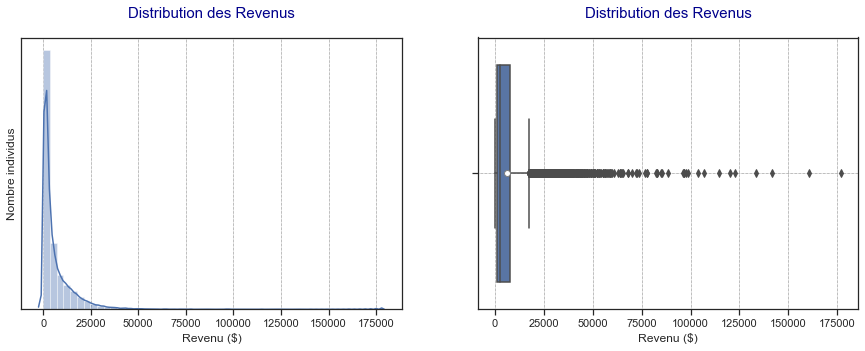

In [8]:
sns.set_style("ticks")
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
ax1 = sns.distplot(pj7['income'])
# sns.scatterplot(y=df['country_code'], x=df['revenu_moy'], data=df)
plt.title("Distribution des Revenus", fontsize=15, color='darkblue', y=1.05)
plt.yticks([])
plt.xlabel("Revenu ($)")
plt.ylabel("Nombre individus")
ax1.grid(color="black", linestyle=':', linewidth=0.5)

plt.subplot(1, 2, 2)
mean_marker = {"marker":"o","markerfacecolor":"white", "markeredgecolor":"grey"}
x = pj7['income']
ax2 = sns.boxplot(x, data=pj7, showmeans=True, meanprops=mean_marker, hue=x, dodge=False, 
                  showfliers=True) # palette='Set1')
ax2.grid(color="black", linestyle=':', linewidth=0.5)
plt.title("Distribution des Revenus", fontsize=15, color='darkblue', y=1.05)
plt.xlabel("Revenu ($)")

plt.savefig('OUTFILES/M4-Dist_revenus.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

<font color="darkblue" size=4>Le passage au Logarithme  $=>$  Rend la distribution <b>"normale (gaussienne)"</b></font>

Nous verrons par la suite ce que cela implique lors d'une régression linéaire.

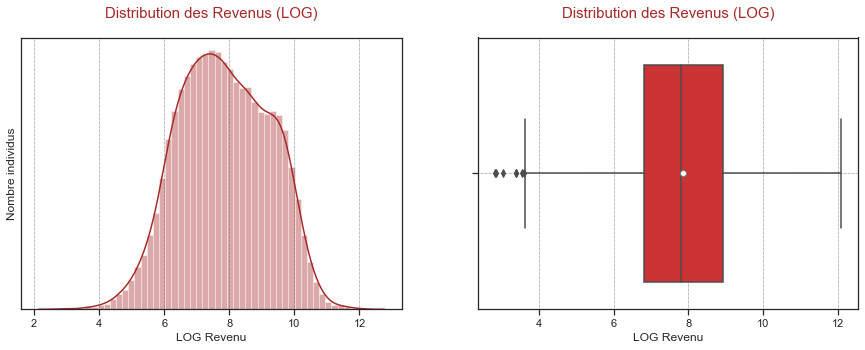

In [9]:
sns.set_style("ticks")
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
ax1 = sns.distplot(np.log(pj7['income']), color='brown')
# sns.scatterplot(y=df['country_code'], x=df['revenu_moy'], data=df)
plt.title("Distribution des Revenus (LOG)", fontsize=15, color='brown', y=1.05)
plt.yticks([])
plt.xlabel("LOG Revenu")
plt.ylabel("Nombre individus")
ax1.grid(color="black", linestyle=':', linewidth=0.5)


plt.subplot(1, 2, 2)
x = np.log(pj7['income'])
ax2 = sns.boxplot(x, data=pj7, showmeans=True, meanprops=mean_marker, hue=x, dodge=False, 
                 showfliers=True, palette='Set1')
plt.title("Distribution des Revenus (LOG)", fontsize=15, color='brown', y=1.05)
plt.xlabel("LOG Revenu")
ax2.grid(color="black", linestyle=':', linewidth=0.5)

plt.savefig('OUTFILES/M4-Dist_revenus_log.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

In [10]:
pj7.head()

,country_code,pj,income,gini,gdpppp
0,ALB,0.816,728.898,30.300,"7,297.000"
1,ALB,0.816,916.662,30.300,"7,297.000"
2,ALB,0.816,"1,010.916",30.300,"7,297.000"
3,ALB,0.816,"1,086.908",30.300,"7,297.000"
4,ALB,0.816,"1,132.700",30.300,"7,297.000"


### Avec la fonction de la librairie "statsmodel" :  smf.OLS

In [11]:
anova_pays = smf.ols('income~country_code', data=pj7).fit()
print(anova_pays.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     97.55
Date:                Thu, 21 May 2020   Prob (F-statistic):               0.00
Time:                        18:30:58   Log-Likelihood:            -1.1458e+05
No. Observations:               11200   AIC:                         2.294e+05
Df Residuals:                   11088   BIC:                         2.302e+05
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2994.8299    

On y voit les paramètres estimés (dans la colonne "Estimate"), mais ici, ce ne sont pas les paramètres qui nous intéressent le plus.

## p_value du  Test de Fisher

Ce qui nous intéresse réellement, c'est le **test de Fisher**.  
La p-valeur de ce test ($0$) est très petite et largement inférieure au risque de 1ère espèce à 5 %.  
On rejette donc l'hypothèse nulle (H0) selon laquelle le revenu moyen par centile est identique pour chaque pays.

*Le pays a donc bien un effet sur le revenu moyen, comme nous en avions l'intuition en regardant la distribution ci-dessous*

Pour obtenir le tableau de l'analyse de la variance, on utilise la commande anova_lm :

In [12]:
sm.stats.anova_lm(anova_pays, typ=2)

,sum_sq,df,F,PR(>F)
country_code,"492,832,628,998.266",111.000,97.546,0.000
Residual,"504,687,076,205.208","11,088.000",nan,nan


##  <font color='#61210B'><u>Conclusion - ANOVA</u></font>  Revenu en fonction du pays

> - La <b>p_value</b> du résultat <b>(=0)</b> nous contraint d'affirmer que le facteur "pays" a donc une influence sur le revenu moyen.  


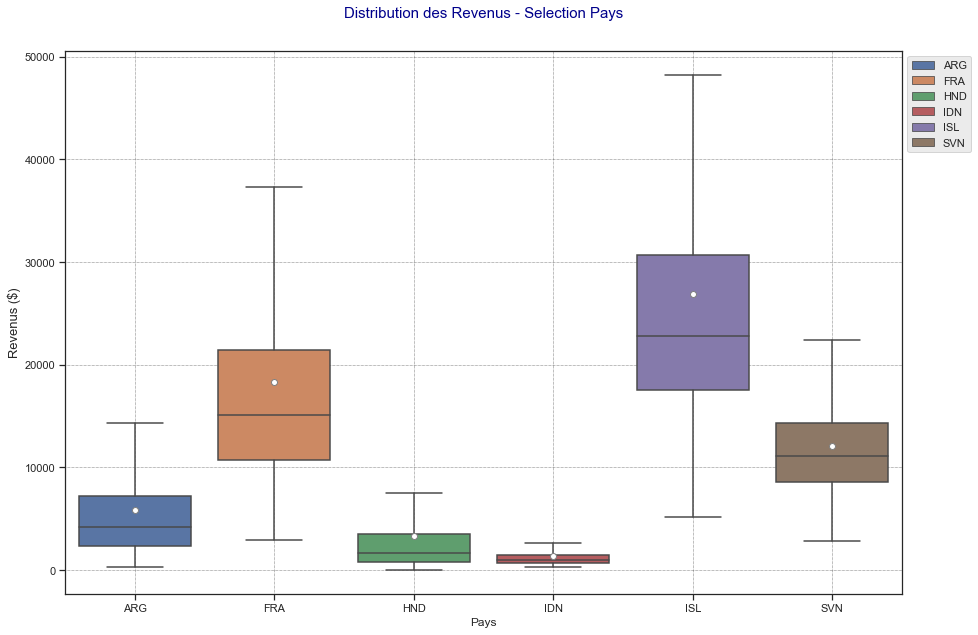

In [13]:
ano6 = pj7[pj7['country_code'].isin(cod_pays)][['country_code', 'income']]
x = ano6['country_code']
y = ano6['income']
sns.set(style="ticks")
mean_marker = {"marker":"o","markerfacecolor":"white", "markeredgecolor":"grey"}
fig, ax = plt.subplots(figsize=[15,10])
ax = sns.boxplot(x, y, data=ano6, showmeans=True, meanprops=mean_marker, hue=x, dodge=False, 
                 showfliers=False) # palette='Set1')
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), facecolor="#E6E6E6")
ax.grid(color="black", linestyle=':', linewidth=0.5)
plt.xlabel("Pays")
plt.ylabel("Revenus ($)", size=13)
plt.title("Distribution des Revenus - Selection Pays", fontsize=15, color='darkblue', y=1.05)
plt.savefig('OUTFILES/M4-Repartition_anova_selection_pays.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

<hr style="height: 3px; color: #839D2D; width: 100%; ">

##  <font color='#61210B'><u>M4 - REGRESSIONS LINEAIRES</u></font>




<font size=4>Appliquez une régression linéaire sur vos données, en n’incluant comme variables explicatives uniquement le revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu. Quel est le pourcentage de variance expliquée par votre modèle ?

Selon ce modèle, donnez la décomposition de variance totale expliquée par :   
<br>

* Le pays de naissance (ie. le revenu moyen et l’indice de Gini)  
* Les autres facteurs non considérés dans le modèle (efforts, chance, etc.)</font>

### Creation Fonction de Regression Lineaire : <font color="darkblue"> $reglin (X,Y)$</font>

##### <font color="darkblue">Paramètres (input)</font>:
* X  =  variable(s) explicative(s)
* Y  =  variable à expliquer

##### <font color="darkgreen">Paramètres (output)</font>:
* <b>var_expl</b> : model.score. Soit le (%) pourcentage de variance expliquée 
* <b>coef</b> : model.coef_
* <b>intrcpt</b> : model.intercept_



In [14]:
def reglin(X,Y):
    model    = LinearRegression().fit(X, Y)
    var_expl = model.score(X, Y)
    coef     = model.coef_
    intrcpt  = model.intercept_
    predict  = model.predict(X)
    return var_expl, coef, intrcpt, predict

<hr style="height: 1px; color: #839D2D; width: 100%; ">

### 1° Cas :  sur 2 variables explicatives 
* Revenu moyen du pays  (gdpppp)
* Indice de gini

In [15]:
pj7.head()

,country_code,pj,income,gini,gdpppp
0,ALB,0.816,728.898,30.300,"7,297.000"
1,ALB,0.816,916.662,30.300,"7,297.000"
2,ALB,0.816,"1,010.916",30.300,"7,297.000"
3,ALB,0.816,"1,086.908",30.300,"7,297.000"
4,ALB,0.816,"1,132.700",30.300,"7,297.000"


In [16]:
# Version 2 Variables sans & avec Logarithmes
dfreglin2 = pj7[['income', 'gini', 'gdpppp']]
dfreglin2log = pd.concat([np.log(pj7['income']), pj7[['gini']], np.log(pj7['gdpppp'])], axis = 1)

<font color="darkblue" size=3>Version <b>2 vars <u>SANS</u></b> Logarithmes </font>

In [17]:
X = dfreglin2[['gdpppp', 'gini']]
Y = dfreglin2['income'].values
var, a, b, predict = reglin(X,Y)
print("Variance expliquée (Coeff.R²) = : ", round(var, 4)*100, "(%)")

Variance expliquée (Coeff.R²) = :  44.6 (%)


Tableau Recap avec <b>Statsmodel</b></font>

In [18]:
reglin2 = smf.ols('income~gdpppp+gini', data=dfreglin2).fit()
print(reglin2.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     4508.
Date:                Thu, 21 May 2020   Prob (F-statistic):               0.00
Time:                        18:30:59   Log-Likelihood:            -1.1509e+05
No. Observations:               11200   AIC:                         2.302e+05
Df Residuals:                   11197   BIC:                         2.302e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -101.7025    375.528     -0.271      0.7

<b>RESIDUS = </b> Représente la variance inexpliquée par le modèle.  
Ce sont d'autres variables que l'on aurait pu ajouter a ce modèle pour expliquer au mieux le revenu d'une personne :   
* Niveau d'etude atteint
* Santé, equlibre physique d'une personne
* Facteur CHANCE
* Facteur effort fourni pour s'éveler


<font color="darkblue" size=3>Analyse des <b>Residus</b> du modèle <b>2vars_sans_log</b></font> 

Sachant qu'il y a <b>44.6(%)</b> de Variance expliquée (Coeff.R²) par ce modèle, 

> RESIDUS $=>$ <b>55,4(%)</b> de variance non expliquée

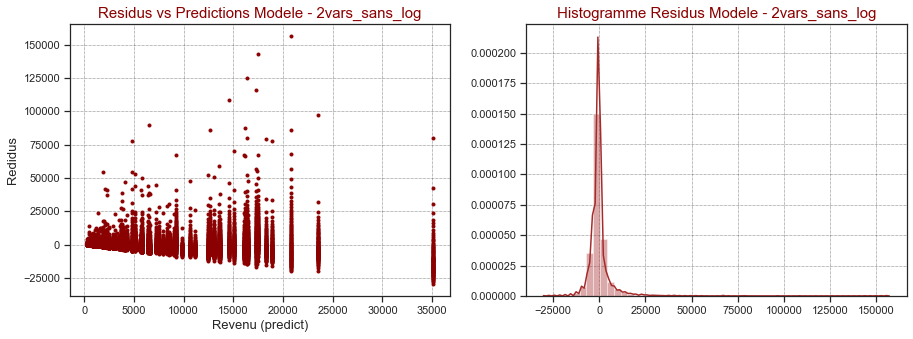

In [19]:
fig, ax = plt.subplots(figsize=[15,5])
plt.subplot(1, 2, 1)
plt.plot(predict, Y-predict,'.', color="darkred")
plt.grid(color="black", linestyle=':', linewidth=0.5)
plt.xlabel("Revenu (predict)", size=13)
plt.ylabel("Redidus", size=13)
plt.title("Residus vs Predictions Modele - 2vars_sans_log", size=15, color="darkred")

plt.subplot(1, 2, 2)
sns.distplot(Y-predict, color='brown')
plt.grid(color="black", linestyle=':', linewidth=0.5)
plt.title("Histogramme Residus Modele - 2vars_sans_log", size=15, color="darkred")

plt.savefig('OUTFILES/M4-Residus_2var_sans_log.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

<font color="darkred" size=4>    
* Le modèle ne semble pas linéaire car s'il l'était, le nuage de point devrait être centré sur l'axe Y=0 (figure gauche).  
* Quand le modèle est bon, la distribution des "résidus" suit une loi normale (gaussienne) (figure droite).</font>

<font color="darkblue" size=3>Version <b>2 vars <u>AVEC</u></b> Logarithmes </font>

In [20]:
X = dfreglin2log[['gdpppp', 'gini']]
Y = dfreglin2log['income'].values
var, a, b, predict = reglin(X,Y)
print("Variance expliquée (Coeff.R²) = : ", round(var, 4)*100, "(%)")

Variance expliquée (Coeff.R²) = :  65.9 (%)


Tableau Recap avec <b>Statsmodel</b></font>

In [21]:
reglin2log = smf.ols('income~gdpppp+gini', data=dfreglin2log).fit()
print(reglin2log.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                 1.082e+04
Date:                Thu, 21 May 2020   Prob (F-statistic):               0.00
Time:                        18:31:00   Log-Likelihood:                -13497.
No. Observations:               11200   AIC:                         2.700e+04
Df Residuals:                   11197   BIC:                         2.702e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0174      0.077     13.233      0.0

<font color="darkblue" size=3>Analyse des <b>Residus</b> du modèle <b>2vars_avec_log</b></font> 

Sachant qu'il y a <b>65.9(%)</b> de Variance expliquée (Coeff.R²) par ce modèle, 

> RESIDUS $=>$ <b>34,1(%)</b> de variance non expliquée


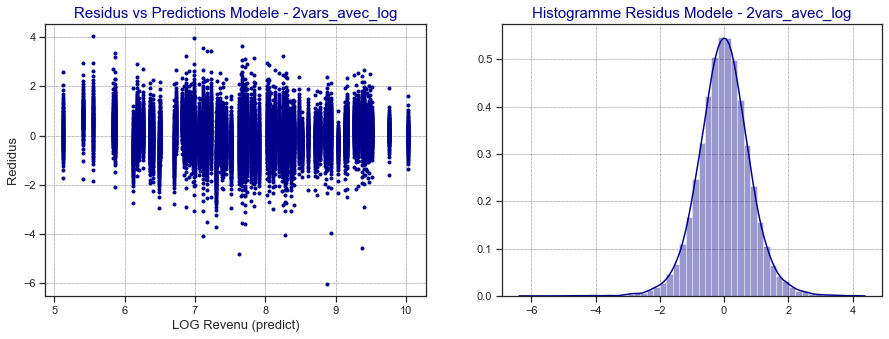

In [22]:
fig, ax = plt.subplots(figsize=[15,5])
plt.subplot(1, 2, 1)
plt.plot(predict, Y-predict,'.', color="darkblue")
plt.grid(color="black", linestyle=':', linewidth=0.5)
plt.xlabel("LOG Revenu (predict)", size=13)
plt.ylabel("Redidus", size=13)
plt.title("Residus vs Predictions Modele - 2vars_avec_log", size=15, color="darkblue")

plt.subplot(1, 2, 2)
sns.distplot(Y-predict, color='darkblue')
plt.grid(color="black", linestyle=':', linewidth=0.5)
plt.title("Histogramme Residus Modele - 2vars_avec_log", size=15, color="darkblue")

plt.savefig('OUTFILES/M4-Residus_2var_avec_log.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

<font color="darkblue" size=4>    
* Ici, on constate mieux la relation linéaire, le nuage de point paraissant centré sur l'axe Y=0 (figure gauche).  
* La distribution des "résidus" de ce modèle semble suivre une une loi normale (gaussienne) (figure droite).</font>

<hr style="height: 1px; color: #839D2D; width: 100%; ">

### 2° Cas :  sur 3 variables explicatives  
Ajoutons une variable (classe_revenu_parent) afin d'améliorer le modèle précédent
* Revenu moyen du pays  (gdpppp)
* Indice de gini
* Classe de revenu des parents

Cette fois-ci, je suis obligé de prendre la dataframe conséquent conteanant les 5'600'000 lignes car c'est lui qui intégre la notion de classe de revenu d'un parent pour un enfant.

In [23]:
wid.head()

,country_code,pj,income,gini,gdpppp,c_i_parent
0,ALB,0.816,728.898,30.300,"7,297.000",1
1,ALB,0.816,728.898,30.300,"7,297.000",1
2,ALB,0.816,728.898,30.300,"7,297.000",1
3,ALB,0.816,728.898,30.300,"7,297.000",1
4,ALB,0.816,728.898,30.300,"7,297.000",1


In [24]:
# Version 3 Variables sans & avec Logarithmes
dfreglin3 = wid[['income', 'gini', 'gdpppp', 'c_i_parent']]
dfreglin3log = pd.concat([np.log(wid['income']), wid[['gini']], np.log(wid['gdpppp']), wid[['c_i_parent']]], axis = 1)

<font color="darkblue" size=3>Version <b>3 vars <u>SANS</u></b> Logarithmes </font>

In [25]:
X = dfreglin3[['gdpppp', 'gini', 'c_i_parent']]
Y = dfreglin3['income'].values
var, a, b, predict = reglin(X,Y)
print("Variance expliquée (Coeff.R²) = : ", round(var, 4)*100, "(%)")

Variance expliquée (Coeff.R²) = :  45.57 (%)


Tableau Recap avec <b>Statsmodel</b></font>

In [26]:
reglin3 = smf.ols('income~gdpppp+gini+c_i_parent', data=dfreglin3).fit()
print(reglin3.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                 1.563e+06
Date:                Thu, 21 May 2020   Prob (F-statistic):               0.00
Time:                        18:31:05   Log-Likelihood:            -5.7496e+07
No. Observations:             5600000   AIC:                         1.150e+08
Df Residuals:                 5599996   BIC:                         1.150e+08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1776.1685     17.469   -101.675      0.0

<font color="darkblue" size=3>Analyse des <b>Residus</b> du modèle <b>3vars_sans_log</b></font> 

Sachant qu'il y a <b>45.5(%)</b> de Variance expliquée (Coeff.R²) par ce modèle, 

> RESIDUS $=>$ <b>54,5(%)</b> de variance non expliquée

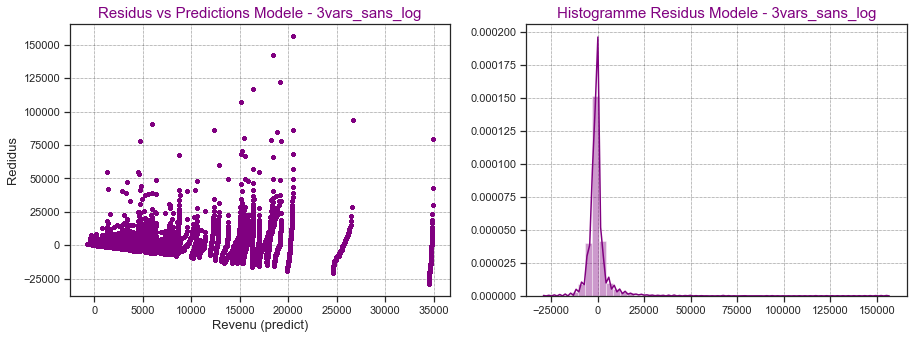

In [27]:
fig, ax = plt.subplots(figsize=[15,5])
plt.subplot(1, 2, 1)
plt.plot(predict, Y-predict,'.', color="purple")
plt.grid(color="black", linestyle=':', linewidth=0.5)
plt.xlabel("Revenu (predict)", size=13)
plt.ylabel("Redidus", size=13)
plt.title("Residus vs Predictions Modele - 3vars_sans_log", size=15, color="purple")

plt.subplot(1, 2, 2)
sns.distplot(Y-predict, color='purple')
plt.grid(color="black", linestyle=':', linewidth=0.5)
plt.title("Histogramme Residus Modele - 3vars_sans_log", size=15, color="purple")
plt.savefig('OUTFILES/M4-Residus_3var_sans_log.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

<font size=3> Mêmes constations quasiement que pour le modèle a 2 variables sans logarithmes.</font>  
<font color="darkred" size=4>    
* Pas de relation linéaire évidente : nuage de point mal centré sur l'axe Y=0 (gauche).  
* Distribution des "résidus" non gaussienne (figure droite).</font>

<font color="darkblue" size=3>Version <b>3 vars <u>AVEC</u></b> Logarithmes </font>

In [28]:
X = dfreglin3log[['gdpppp', 'gini', 'c_i_parent']]
Y = dfreglin3log['income'].values
var, a, b, predict = reglin(X,Y)
print("Variance expliquée (Coeff.R²) = : ", round(var, 4)*100, "(%)")

Variance expliquée (Coeff.R²) = :  67.19000000000001 (%)


Tableau Recap avec <b>Statsmodel</b></font>

In [29]:
reglin3log = smf.ols('income~gdpppp+gini+c_i_parent', data=dfreglin3log).fit()
print(reglin3log.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                 3.823e+06
Date:                Thu, 21 May 2020   Prob (F-statistic):               0.00
Time:                        18:31:33   Log-Likelihood:            -6.6402e+06
No. Observations:             5600000   AIC:                         1.328e+07
Df Residuals:                 5599996   BIC:                         1.328e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6803      0.003    197.328      0.0

<font color="darkblue" size=3>Analyse des <b>Residus</b> du modèle <b>3vars_avec_log</b></font> 

Sachant qu'il y a <b>67.2(%)</b> de Variance expliquée (Coeff.R²) par ce modèle, 

> RESIDUS $=>$ <b>32,8(%)</b> de variance non expliquée

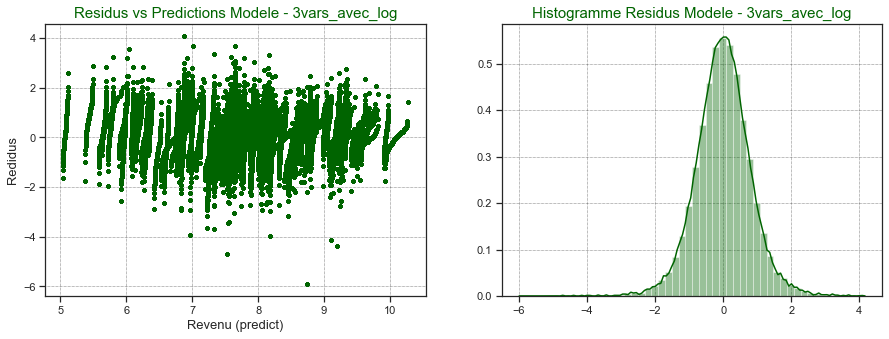

In [30]:
fig, ax = plt.subplots(figsize=[15,5])
plt.subplot(1, 2, 1)
plt.plot(predict, Y-predict,'.', color="darkgreen")
plt.grid(color="black", linestyle=':', linewidth=0.5)
plt.xlabel("Revenu (predict)", size=13)
plt.ylabel("Redidus", size=13)
plt.title("Residus vs Predictions Modele - 3vars_avec_log", size=15, color="darkgreen")

plt.subplot(1, 2, 2)
sns.distplot(Y-predict, color='darkgreen')
plt.grid(color="black", linestyle=':', linewidth=0.5)
plt.title("Histogramme Residus Modele - 3vars_avec_log", size=15, color="darkgreen")
plt.savefig('OUTFILES/M4-Residus_3var_avec_log.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

<font color="darkblue" size=4>    
* Ici, on constate mieux la realtion linéaire, le nuage de point paraissant centré sur l'axe Y=0 (figure gauche).  
* La distribution des "résidus" de ce modèle semble suivre une une loi normale (gaussienne) (figure droite).

<b>Ce modèle semble donc le meilleur des 4 étudiés pour expliquer au plus juste le revenu d'une personne.</b>
</font>

<hr style="height: 2px; color: #839D2D; width: 100%; ">

### Question :
<br>
<font color="darkblue" size=4>
    
> En observant le coefficient de régression associé à l’indice de Gini, peut-on affirmer que le fait de vivre dans un pays plus inégalitaire favorise plus de personnes qu’il n’en défavorise ?
</font>



In [31]:
dfreglin3log

,income,gini,gdpppp,c_i_parent
0,6.592,30.300,8.895,1
1,6.592,30.300,8.895,1
2,6.592,30.300,8.895,1
3,6.592,30.300,8.895,1
4,6.592,30.300,8.895,1
...,...,...,...,...
5599995,11.319,63.733,9.170,16
5599996,11.319,63.733,9.170,16
5599997,11.319,63.733,9.170,16
5599998,11.319,63.733,9.170,16


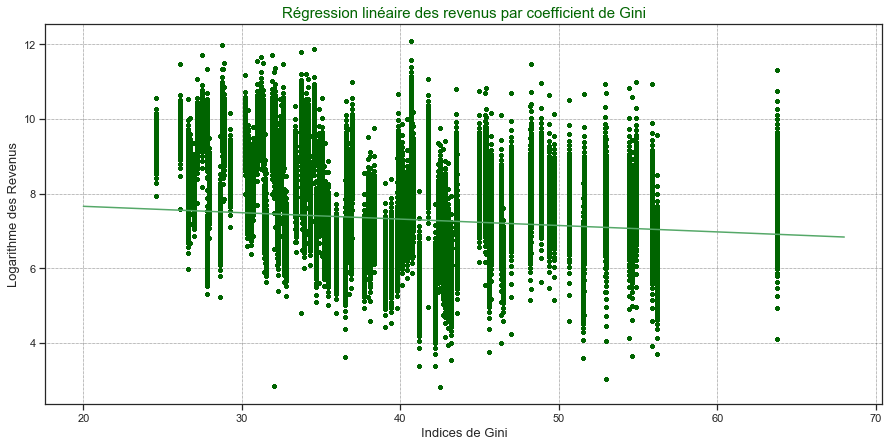

In [32]:
x_gini = np.arange(20, dfreglin3log['gini'].max()+5)
y_gini = a[1]*x_gini + 8
xg = dfreglin3log['gini']
yg = dfreglin3log['income']
fig, ax = plt.subplots(figsize=[15,7])
plt.plot(xg, yg,'.', color="darkgreen")
plt.plot(x_gini, y_gini, '-g')
plt.grid(color="black", linestyle=':', linewidth=0.5)
plt.xlabel("Indices de Gini", size=13)
plt.ylabel("Logarithme des Revenus", size=13)
plt.title("Régression linéaire des revenus par coefficient de Gini", size=15, color="darkgreen")
plt.show()

### Réponse :
<br>
<font color="darkgreen" size=4>
    
> L'indice de Gini va de 0 (égalité parfaite) à 1 (inégalité parfaite).   
Le coefficient directeur de la droite de regression linéaire de gini étant négatif, plus l'indice de Gini va augmenter, plus les revenus vont diminuer.  
Donc NON, on ne peut pas affirmer que le fait de vivre dans un pays plus inégalitaire plus de personnes qu'il n'en dévavorise.
</font>



<hr style="height: 3px; color: #839D2D; width: 100%; ">

##  <font color='#61210B'><u>M4 - ANALYSE APPROFONDIE DES RESIDUS DU MODELE  3_VARS_AVEC_LOG</u></font>


* Nous allons ici réaliser les tests à un niveau α=5%
* Récupérons n, le nombre d'individus de l'échantillon, et p , le nombre de variables.


<img src="DATA/images/Bon_Residu.png" width="500" align=left>


In [33]:
n = dfreglin3log.shape[0]
p = 3
alpha = 0.05

In [34]:
dfreglin3log.head()

,income,gini,gdpppp,c_i_parent
0,6.592,30.300,8.895,1
1,6.592,30.300,8.895,1
2,6.592,30.300,8.895,1
3,6.592,30.300,8.895,1
4,6.592,30.300,8.895,1


In [35]:
print(reglin3log.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                 3.823e+06
Date:                Thu, 21 May 2020   Prob (F-statistic):               0.00
Time:                        18:32:05   Log-Likelihood:            -6.6402e+06
No. Observations:             5600000   AIC:                         1.328e+07
Df Residuals:                 5599996   BIC:                         1.328e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6803      0.003    197.328      0.0

Nous allons mener des analyses sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé analyses.

In [36]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

## Calcul des leviers  (observation atypique)

Un levier est considéré comme un point atypique.  
On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de :  
> $ Seuil = 2∗\frac{p+1}{n}$.

<img src="DATA/images/Levier_effet.png" width="500" align=left>

In [37]:
analyses['levier'] = reglin3log.get_influence().hat_matrix_diag
seuil_levier = 2*(p+1)/n

<i><font color="darkblue" size=4>
* Sélection des points pour lesquels le levier est supérieur au seuil
* Recherche des pays correspondant</font></i>


In [38]:
dflv = analyses[analyses['levier'] > seuil_levier] 
tx1 = np.round(100*dflv.shape[0]/dfreglin3log.shape[0], 3)
print("Nombre d'observations dont levier > seuil :", dflv.shape[0], " soit ", tx1, "(%) du Dataset")
err = pd.merge(dflv, wid, left_index=True, right_index=True).drop_duplicates()
err.groupby(['country_code']).size()\
                             .reset_index(name='nb_obs')\
                             .sort_values(['nb_obs'], ascending=False) \
                             .head(10)

Nombre d'observations dont levier > seuil : 285500  soit  5.098 (%) du Dataset


,country_code,nb_obs
22,ZAF,50000
19,TLS,34500
2,CAF,27500
15,NOR,21500
7,GTM,20500
18,SVN,20500
20,URY,16000
14,MYS,13500
21,YEM,13500
17,RUS,11000


##### Graphe trop long à executer ...

In [39]:
# x1 = 2049828
# plt.figure(figsize=(15,8))
# plt.bar(analyses['obs'], analyses['levier'])
# plt.xticks(np.arange(0, n, step=5))
# plt.xlabel('Observation')
# plt.ylabel('Leviers')
# plt.plot([0, n], [seuil_levier, seuil_levier], color='r')
# plt.xlim(x1-10,X1+190)
# plt.show()

## Calcul des résidus studentisés

Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [40]:
analyses['rstudent'] = reglin3log.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

<i><font color="darkblue" size=4>
* Sélection des points pour lesquels les residus ne sont pas compris entre les bornes du seuil
* Recherche des pays correspondant</font></i>

In [41]:
dfrs = analyses[abs(analyses['rstudent']) > seuil_rstudent] 
tx1 = np.round(100*dfrs.shape[0]/dfreglin3log.shape[0], 3)
print("Nombre d'observations dont residus hors seuil :", dfrs.shape[0], " soit ", tx1, "(%) du Dataset")#### GRAPHE TROP LONG A EXECUTER SUR CE DATASET

err = pd.merge(dfrs, wid, left_index=True, right_index=True).drop_duplicates()
err.groupby(['country_code']).size()\
                             .reset_index(name='nb_obs')\
                             .sort_values(['nb_obs'], ascending=False) \
                             .head(10)

Nombre d'observations dont residus hors seuil : 297000  soit  5.304 (%) du Dataset


,country_code,nb_obs
93,SWZ,21500
40,HND,11500
104,ZAF,11000
10,BOL,10000
75,NIC,7000
20,COL,7000
17,CIV,6500
11,BRA,6000
65,MEX,6000
79,PAN,6000


##### Graphe trop long à executer ...

In [42]:
# x1 = 2099829
# plt.figure(figsize=(15,8))
# plt.bar(analyses['obs'], analyses['rstudent'])
# plt.xticks(np.arange(0, n, step=10))
# plt.xlabel('Observation')
# plt.ylabel('Résidus studentisés')
# plt.plot([0, n], [seuil_rstudent, seuil_rstudent], color='r')
# plt.plot([0, n], [-seuil_rstudent, -seuil_rstudent], color='r')
# plt.xlim(x1-10,X1+190)
# plt.show()

## Détermination de la distance de Cook

On considèrera que les observations sont très influentes si 
> <font size=4>$ Seuil = {\displaystyle D_{i}>{\frac{4}{(n-p)}} }$ </font>

Pour trouver la distance de Cook, nous exécutons ceci :

<font color="darkred" size=5> Durée extremement longue sur dfreglin3log - choix etude sur dfreglin2log </font>

In [43]:
n = dfreglin2log.shape[0]
p = 2
analyses2 = pd.DataFrame({'obs':np.arange(1, n+1)})
dfreglin2log.head()

,income,gini,gdpppp
0,6.592,30.300,8.895
1,6.821,30.300,8.895
2,6.919,30.300,8.895
3,6.991,30.300,8.895
4,7.032,30.300,8.895


In [44]:
influence = reglin2log.get_influence().summary_frame()
analyses2['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

<i><font color="darkblue" size=4>
* Sélection des points pour lesquels la distance de cook est supérieure au seuil
* Recherche des pays correspondant</font></i>


In [45]:
dfck = analyses2[abs(analyses2['dcooks']) > seuil_dcook] 
tx1 = np.round(100*dfck.shape[0]/dfreglin2log.shape[0], 3)
print("Nombre d'observations dont la distance de Cook est > seuil :", dfck.shape[0], " soit ", tx1, "(%) du Dataset")
err = pd.merge(dfck, pj7, left_index=True, right_index=True).drop_duplicates()
err.groupby(['country_code']).size()\
                             .reset_index(name='nb_obs')\
                             .sort_values(['nb_obs'], ascending=False) \
                             .head(10)

Nombre d'observations dont la distance de Cook est > seuil : 642  soit  5.732 (%) du Dataset


,country_code,nb_obs
83,ZAF,54
74,SWZ,50
33,HND,36
9,CAF,34
45,LBR,33
16,COL,26
7,BOL,25
8,BRA,25
63,PAN,23
32,GTM,19


##### Graphe trop long à executer ...

In [46]:
# x1 = 11100
# plt.figure(figsize=(15,8))
# plt.bar(analyses['obs'], analyses['dcooks'])
# plt.xticks(np.arange(0, n, step=5))
# plt.xlabel('Observation')
# plt.ylabel('Distance Cook')
# plt.plot([0, n], [seuil_dcook, seuil_dcook], color='r')
# plt.xlim(x1-10,X1+190)
# plt.ylim(0,0.04)
# plt.show()

<font color="darkred" size=4>On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.</font>

## Test de l’homoscédasticité

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [47]:
variables = reglin3log.model.exog
from statsmodels.stats.outliers_influence import variance_inflation_factor
_, pval, __, f_pval = sm.stats.diagnostic.het_breuschpagan(reglin3log.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 0.0


La p-valeur ici est très nettemenent inférieure au seuil de $5$% :   
On rejette donc l'hypothèse nulle $(H0)$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).



In [48]:
#Résidus de reglin3log  :
Y-predict

array([-1.28326558, -1.28326558, -1.28326558, ...,  3.66966676,
        3.66966676,  3.66966676])

## Test de la normalité des résidus

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [49]:
###  Test kolmogorov-smirnoff
st.kstest(Y-predict, 'norm')

KstestResult(statistic=0.07536352873668928, pvalue=0.0)

In [50]:
shapiro(reglin3log.resid)

C:\Users\boiss\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9962407946586609, 0.0)

Ici, l'hypothèse de normalité est remise en cause (p-value = 0.0 < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille gigantesque (5'600'000), permettent de dire que **les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien par shapiro-Wilk.

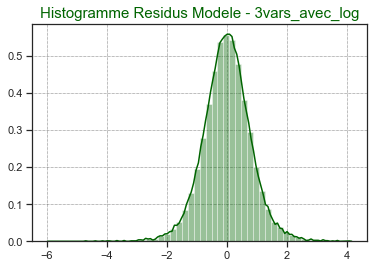

In [51]:
sns.distplot(Y-predict, color='darkgreen')
plt.grid(color="black", linestyle=':', linewidth=0.5)
plt.title("Histogramme Residus Modele - 3vars_avec_log", size=15, color="darkgreen")
plt.show()

In [52]:
dureetotale = round(time.time() - trt_start_time, 5)
print("--- Durée TOTALE du Notebook PJ7_M3 --- ", "%s seconds" % dureetotale)

--- Durée TOTALE du Notebook PJ7_M3 ---  94.49632 seconds
